In [1]:
    from scipy.io import arff
    import pandas as pd

In [2]:
def getDataSet():
    curr_path = os.getcwd()
    data_path = os.path.join(curr_path, "dataset")
    data_path = os.path.join(data_path, "EEG_Eye_State")
    file_path = os.path.join(data_path, "EEGEyeState.arff")

    data, meta = arff.loadarff(file_path)
    data = pd.DataFrame(data)
    # Convierto la columna final a entero
    data["eyeDetection"] = data["eyeDetection"].astype('int')
    dataDict = {}
    for column in data.columns:
        if column != 'eyeDetection':
            dataDict[column] = [[]]
    #print(dataDict)
    cnt = 0
    for index, row in data.iterrows():
        if cnt == 140:
            cnt = 0
            for key in dataDict.keys():
                dataDict[key].append([])

        for key in dataDict.keys():
                dataDict[key][-1].append(row[key])

        cnt += 1

    
    dataSet = []
    listBounds = []
    for key in dataDict.keys():
        data = dataDict[key]
        data.pop()
        data.pop(0)
        # print('----------------------------------')
        # print(data)
        # print('----------------------------------')
        _max = max(map(max, data))
        _min = min(map(min, data))
        upperBound = _max + (_max - _min) * 0.1
        lowerBound = _min - (_max - _min) * 0.1
        listBounds.append((lowerBound, upperBound))
        dataSet.append(data)

    #plot original data
    #print(dataDict)
    return dataSet, dataDict, listBounds

In [3]:
dataSet, dataDict, listBounds = getDataSet()

In [4]:
# set parameters
from _slade_mts import SladeMts
segmentLength = 20
paaSize = 4 # every single time
alphabetSize = 3
pStep = 10
seriesLen = 140
sladeMts = SladeMts(dataSet = dataSet, listBounds = listBounds, segmentLength = segmentLength, alphabetSize = alphabetSize, paaSize = paaSize, pStep = pStep, seriesLen = seriesLen)
listPatterns = sladeMts.patternGenerate()
listNewTimeSeries, patternLocations = sladeMts.dataTransformation(dataSet, listPatterns)

正在生成patterns...
0.0
0.07142857142857142
0.14285714285714285
0.21428571428571427
0.2857142857142857
0.35714285714285715
0.42857142857142855
0.5
0.5714285714285714
0.6428571428571429
0.7142857142857143
0.7857142857142857
0.8571428571428571
0.9285714285714286
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


(105, 12)
              0            1            2           3            4  \
0    565.654495  3760.736200   602.781374  458.378775  1444.105737   
1    361.324927  3837.085633   916.205393  326.724432   784.294122   
2    148.794680  3833.512651   818.636554  352.059968   636.228728   
3    205.710611  3810.648253   549.330763  372.776695   965.404060   
4    189.348162  3805.416041   695.809267  440.650994   832.041720   
..          ...          ...          ...         ...          ...   
100  184.802050  3846.503824   700.319864  628.120818   761.223930   
101  238.688815  3781.642015   719.675469  557.523506   851.255923   
102  377.977708  3825.755252  1132.200809  555.057585   385.268687   
103  362.402991  3788.434781   993.664056  590.505748   486.734129   
104  182.243940  3802.642641   784.510920  507.561397   676.207599   

               5           6           7            8           9          10  \
0     351.194118  370.504474  267.800818  1399.022644  929.629482  2

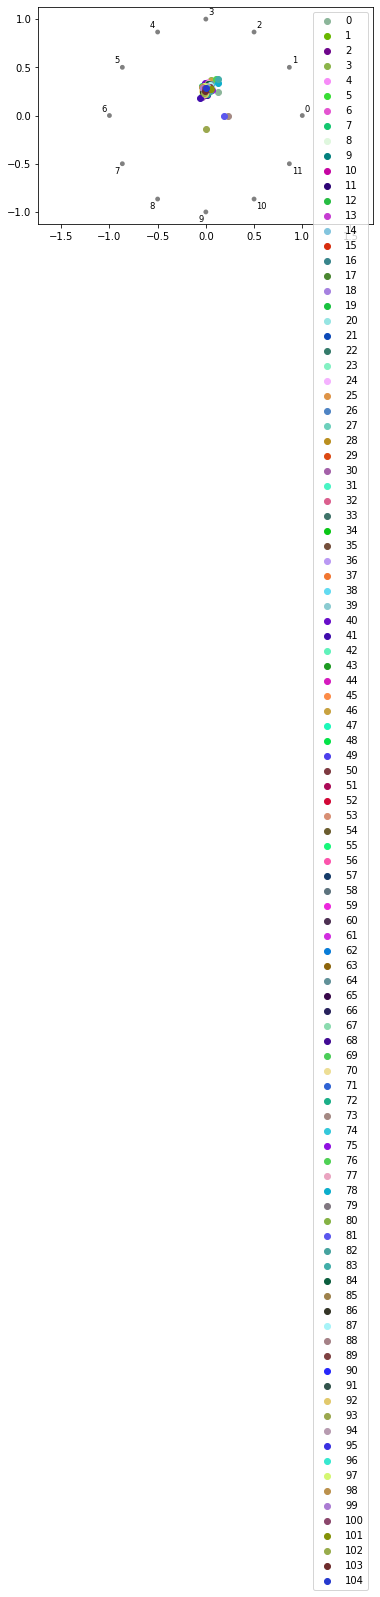

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

featureNum = 12
selectedFeature, idx = SladeMts.featureSelection(listNewTimeSeries, featureNum)

# -------------- plot ----------------#
shape = selectedFeature.shape
print(shape)
columnNames = []
for i in range(0, shape[1]):
    columnNames.append(str(i))
df = pd.DataFrame(selectedFeature, columns = columnNames)
df[str(shape[1])] = '1'
for i in range(0, shape[0]):
    df[str(shape[1])][i] = str(i)
print(df)
pd.plotting.radviz(df, str(shape[1]))
plt.show()

In [6]:
from sklearn.cluster import DBSCAN
import numpy as np
res = []
# 迭代不同的eps值
for eps in np.arange(2000,3500,50):
    # 迭代不同的min_samples值
    for min_samples in range(2,10):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        # 模型拟合
        dbscan.fit(selectedFeature)
        # 统计各参数组合下的聚类个数（-1表示异常点）
        n_clusters = len([i for i in set(dbscan.labels_) if i != -1])
        # 异常点的个数
        outliners = np.sum(np.where(dbscan.labels_ == -1, 1,0))
        # 统计每个簇的样本个数
        stats = str(pd.Series([i for i in dbscan.labels_ if i != -1]).value_counts().values)
        res.append({'eps':eps,'min_samples':min_samples,'n_clusters':n_clusters,'outliners':outliners,'stats':stats})
# 将迭代后的结果存储到数据框中
pd.set_option('display.max_rows', None)        
df = pd.DataFrame(res)
print(df)

      eps  min_samples  n_clusters  outliners      stats
0    2000            2           2          1  [102   2]
1    2000            3           1          3      [102]
2    2000            4           1          3      [102]
3    2000            5           1          3      [102]
4    2000            6           1          3      [102]
5    2000            7           1          3      [102]
6    2000            8           1          3      [102]
7    2000            9           1          3      [102]
8    2050            2           2          1  [102   2]
9    2050            3           1          3      [102]
10   2050            4           1          3      [102]
11   2050            5           1          3      [102]
12   2050            6           1          3      [102]
13   2050            7           1          3      [102]
14   2050            8           1          3      [102]
15   2050            9           1          3      [102]
16   2100            2         

In [7]:
from _slade_mts import SladeMts
eps = 2100
min_samples = 4
sensibility = 3
anomalyIndex,anomalyLocations = SladeMts.anomalyDetection_DBScan(selected_features = selectedFeature, features_idx = idx, patternLocations = patternLocations, eps = eps, min_samples = min_samples, sensibility = sensibility)
print(anomalyIndex)
print(anomalyLocations)

[73, 81, 93]
[[(11, 0, 140), (1, 0, 140)], [(11, 0, 140), (1, 0, 140)], [(11, 0, 140), (7, 0, 140), (1, 0, 140)]]


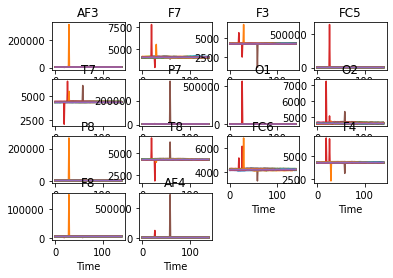

In [19]:
fig = plt.figure()
cnt = 1
for key in dataDict.keys():
    ax = fig.add_subplot(4, 4, cnt)
    ax.set_title(key)
    ax.set_xlabel('Time')
    data = dataDict[key]
    for i in range(0, len(data)):
        ax.plot(data[i])
    cnt += 1
plt.show()

In [9]:
anomalyDict = {}

for i in range(0, len(anomalyIndex)):
    for location in anomalyLocations[i]:
        dim = location[0]
        if anomalyDict.get(location[0]) == None:
            anomalyDict[dim] = []
        anomalyDict[dim].append((anomalyIndex[i], location[1], location[2]))
print(anomalyDict) 

{11: [(73, 0, 140), (81, 0, 140), (93, 0, 140)], 1: [(73, 0, 140), (81, 0, 140), (93, 0, 140)], 7: [(93, 0, 140)]}


!!!
!!!


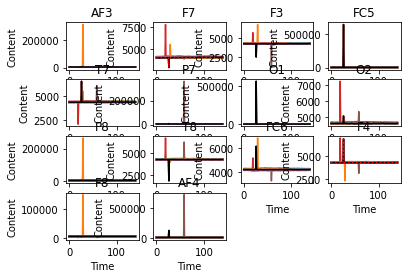

In [10]:
fig = plt.figure()
cnt = 1
mainSeries = 73
for key in dataDict.keys():
    ax = fig.add_subplot(4, 4, cnt)
    ax.set_title(key)
    ax.set_xlabel('Time')
    ax.set_ylabel('Content')
    data = dataDict[key]
    for series in data:
        ax.plot(series)
    ax.plot(data[mainSeries], color = 'black')

    if anomalyDict.get((cnt-1)) != None:
        locations = anomalyDict[cnt-1]
        for location in locations:
            if location[0] == mainSeries:
                print('!!!')
                ax.plot(data[mainSeries][location[1]:location[2]], color = 'red', linestyle=':')
            
    cnt += 1
plt.show()

!!!
!!!


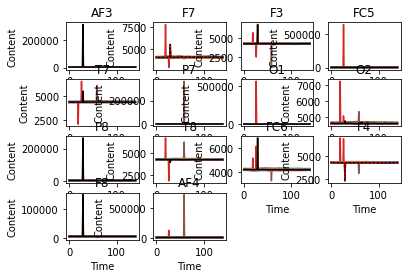

In [11]:
fig = plt.figure()
cnt = 1
mainSeries = 81
for key in dataDict.keys():
    ax = fig.add_subplot(4, 4, cnt)
    ax.set_title(key)
    ax.set_xlabel('Time')
    ax.set_ylabel('Content')
    data = dataDict[key]
    for series in data:
        ax.plot(series)
    ax.plot(data[mainSeries], color = 'black')

    if anomalyDict.get((cnt-1)) != None:
        locations = anomalyDict[cnt-1]
        for location in locations:
            if location[0] == mainSeries:
                print('!!!')
                ax.plot(data[mainSeries][location[1]:location[2]], color = 'red', linestyle=':')
            
    cnt += 1
plt.show()

!!!
!!!
!!!


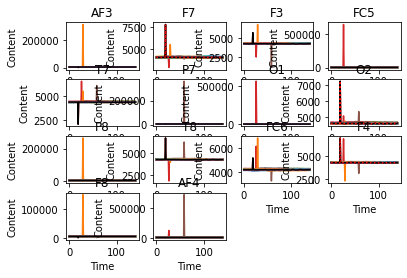

In [12]:
fig = plt.figure()
cnt = 1
mainSeries = 93
for key in dataDict.keys():
    ax = fig.add_subplot(4, 4, cnt)
    ax.set_title(key)
    ax.set_xlabel('Time')
    ax.set_ylabel('Content')
    data = dataDict[key]
    for series in data:
        ax.plot(series)
    ax.plot(data[mainSeries], color = 'black')

    if anomalyDict.get((cnt-1)) != None:
        locations = anomalyDict[cnt-1]
        for location in locations:
            if location[0] == mainSeries:
                print('!!!')
                ax.plot(data[mainSeries][location[1]:location[2]], color = 'red', linestyle=':')
            
    cnt += 1
plt.show()